In [52]:
import pandas as pd
import matplotlib.pyplot as plt

## Open file

In [53]:
df = pd.read_csv("data/btc_ltc.csv", sep=";", index_col=0, parse_dates=[1], infer_datetime_format=True)

In [54]:
df.head()

,date,high,low,open,close,volume,quoteVolume,weightedAverage
0,2020-02-17 00:30:59,0.007463,0.007463,0.007463,0.007463,0.000000,0.000000,0.007463
1,2020-02-17 00:45:00,0.007480,0.007430,0.007470,0.007442,2.587243,347.497942,0.007445
2,2020-02-17 01:00:00,0.007445,0.007400,0.007445,0.007437,1.772896,239.289553,0.007409
3,2020-02-17 01:15:00,0.007435,0.007405,0.007435,0.007425,0.194541,26.202608,0.007424
4,2020-02-17 01:30:00,0.007435,0.007408,0.007425,0.007408,0.087922,11.827702,0.007434


## Optimization Parameters

In [55]:
n = 100
w = 200
P = 0.01

## Structure data

In [56]:
df2 = df[["date", "close"]].set_index("date")

In [57]:
df3 = (df2 - df2.min())/(df2.max() - df2.min()) # min max scaling

In [58]:
df3["ema_100"] = df3["close"].ewm(span=n, adjust=False).mean()

In [59]:
df3.head()

,close,ema_100
date,,
2020-02-17 00:30:59,0.791902,0.791902
2020-02-17 00:45:00,0.784645,0.791758
2020-02-17 01:00:00,0.782629,0.791577
2020-02-17 01:15:00,0.778526,0.791319
2020-02-17 01:30:00,0.772361,0.790943


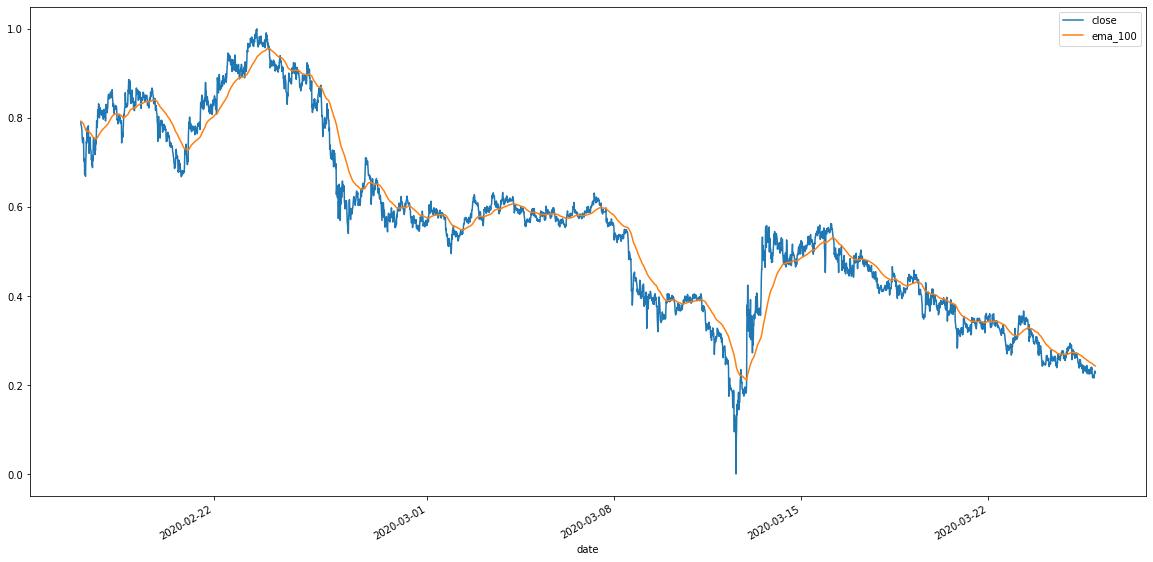

In [60]:
df3.plot(figsize=(20,10))

## Visualize trend

In [61]:
from scripts.funcs import trend

In [62]:
df4 = df3 - df3.shift(w).fillna(0)

In [63]:
df3["trend"] = df4["ema_100"].apply(trend, P=P)

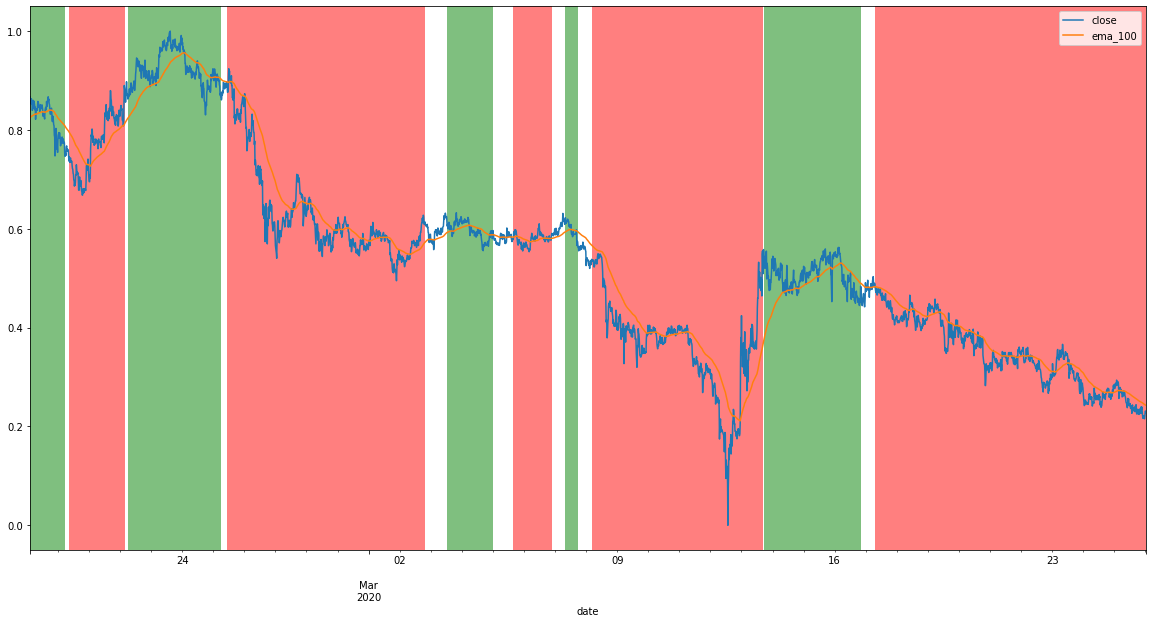

In [64]:
axes = df3[["close", "ema_100"]].iloc[w:,:].plot(figsize=(20,10))
for i, j in zip(df3.index, df3.index[1:]):
    if df3.loc[i, "trend"] == -1:
        color = "r"
    elif df3.loc[i, "trend"] == 1:
        color = "g"
    else:
        color = "w"
    axes.axvspan(i, j, 0, 1, facecolor=color, alpha=0.5)

In [65]:
df5 = df3.iloc[w:, :]

In [66]:
df5.head()

,close,ema_100,trend
date,,,
2020-02-19 02:30:00,0.867124,0.824919,1
2020-02-19 02:45:00,0.854793,0.825510,1
2020-02-19 03:00:00,0.860221,0.826197,1
2020-02-19 03:15:00,0.852866,0.826726,1
2020-02-19 03:30:00,0.863052,0.827445,1


In [67]:
df6 = df5 - df5.shift(1).fillna(0)

In [68]:
df5["trend change"] = df6["trend"] != 0

/Users/pedro/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
df5["close"] = df.set_index("date")["close"]

/Users/pedro/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
df5.head()

,close,ema_100,trend,trend change
date,,,,
2020-02-19 02:30:00,0.007675,0.824919,1,True
2020-02-19 02:45:00,0.007640,0.825510,1,False
2020-02-19 03:00:00,0.007656,0.826197,1,False
2020-02-19 03:15:00,0.007635,0.826726,1,False
2020-02-19 03:30:00,0.007664,0.827445,1,False


In [71]:
df7 = df5[["close", "trend"]][df5["trend change"] == True]

In [72]:
df7.head()

,close,trend
date,,
2020-02-19 02:30:00,0.007675,1
2020-02-20 05:30:00,0.007335,0
2020-02-20 08:30:00,0.007308,-1
2020-02-22 03:30:00,0.007719,0
2020-02-22 06:00:00,0.007662,1


## Measuring profit
1. trend < 0: leverage trade with polo% (margin trading)
2. trend > 0: buy all
3. trend == 0: finish orders

In [73]:
df7["profit"] = 1

In [74]:
prices = df7.close
trend = df7.trend

leverage = 2
lending_rate = 1.02 # per day
rate = 9e-4
stop_loss = .85

profit = [1]
cash = 1

for i, (p, t) in enumerate(zip(prices, trend)):
    if i == 0:
        last_p, last_t = p, t
        continue
    
    if last_t < 0:
        _profit = cash * (1 + leverage * (last_p - p / last_p) * lending_rate * (1 - rate) ** 2)
    if last_t > 0:
        _profit = (cash / last_p) * p * (1 - rate) ** 2
    if last_t == 0:
        _profit = cash
            
    _profit = stop_loss * cash if _profit < stop_loss * cash else _profit
    profit.append(_profit)
        
    last_p, last_t = p, t
    

In [75]:
from operator import mul
from functools import reduce

In [76]:
prod = reduce(mul, profit)

In [77]:
prod

0.4674094832605056

In [78]:
profit

[1,
 0.953986041613342,
 1,
 0.85,
 1,
 0.9999673641634655,
 1,
 0.85,
 1,
 0.9862032524019245,
 1,
 0.85,
 1,
 0.9792890471039669,
 1,
 0.85,
 1,
 0.971888945893936,
 1]